<a href="https://colab.research.google.com/github/kis-balazs/machine-learning/blob/main/MLSandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# !!! sequence timeseries dataset

In [ ]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
df = pd.DataFrame({
    'i1': np.arange(0, 2, .1),
    'i2': np.arange(2, 4, .1),
    'target': np.arange(2, 6, .2) 
})

In [ ]:
xs = df[['i1', 'i2']]
ys = df['target']

### create DataLoader code using torch

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, x, y, time_steps=5):
        """create datasets in the following fashion: i..j x features => j+1 target"""
        self.time_steps = time_steps
        xs, ys = [], []
        for i in range(len(x) - time_steps):
            v = x.iloc[i:(i + time_steps)].values
            xs.append(v)
            ys.append(y.iloc[i + time_steps])
        self.xs = torch.from_numpy(np.array(xs)).float()
        self.ys = torch.from_numpy(np.array(ys)).float()

    def __len__(self):
        return self.xs.shape[0]

    def __getitem__(self, i):
        return self.xs[i], self.ys[i]

In [ ]:
ds = SequenceDataset(
    x=xs,
    y=ys,
    time_steps=3
)
ld_torch = DataLoader(
    ds,
    batch_size=2,
    shuffle=False
)

### create DataLoader code alternative using keras

In [ ]:
from tensorflow import keras

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator
train_gen = keras.preprocessing.sequence.TimeseriesGenerator(
    data=xs,
    targets=ys,
    length=3,
    sampling_rate=1,
    batch_size=1
)

ld_keras = DataLoader(
    train_gen,
    batch_size=2,
    shuffle=False
)

### windowed dataset generator

In [ ]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  if shuffle_buffer:
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
ds = windowed_dataset(xs, window_size=2, batch_size=1)

print(next(iter(ds)))

tf.Tensor(
[[[0.  2. ]
  [0.1 2.1]
  [0.2 2.2]]], shape=(1, 3, 2), dtype=float64)


### compare torch <=> keras

In [ ]:
print('Torch dataloader first value:')
x, y = next(iter(ld_torch))
print('\t<Xs>:', x)
print('\t<Ys>:', y)
print()
print('Keras dataloader first value:')
x, y = next(iter(ld_keras))
print('\t<Xs>:', x)
print('\t<Ys>:', y)

Torch dataloader first value:
	<Xs>: tensor([[[0.0000, 2.0000],
         [0.1000, 2.1000],
         [0.2000, 2.2000]],

        [[0.1000, 2.1000],
         [0.2000, 2.2000],
         [0.3000, 2.3000]]])
	<Ys>: tensor([2.6000, 2.8000])

Keras dataloader first value:
	<Xs>: tensor([[[[0.0000, 2.0000],
          [0.1000, 2.1000],
          [0.2000, 2.2000]]],


        [[[0.1000, 2.1000],
          [0.2000, 2.2000],
          [0.3000, 2.3000]]]], dtype=torch.float64)
	<Ys>: tensor([[2.6000],
        [2.8000]], dtype=torch.float64)


# torch xps

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
# load loss from string :D
import re

pickled_loss = "<class 'torch.nn.modules.loss.L1Loss'>"
loss_str = re.match(r'<class\s\'(?P<name>.*)\'>', pickled_loss).group('name')

l = eval(loss_str)
print(l)

<class 'torch.nn.modules.loss.L1Loss'>


In [ ]:
# load optimizer from string :D

pickled_optimizer = "<class 'torch.optim.adamw.AdamW'>"
optimizer_str = re.match(r'<class\s\'(?P<name>.*)\'>', pickled_optimizer).group('name')
optimizer_components = optimizer_str.split('.')
del optimizer_components[2]
optimizer_str = '.'.join(optimizer_components)

l = eval(optimizer_str)
print(l)

<class 'torch.optim.adamw.AdamW'>


## RNN **nlp**

In [ ]:
import torch
from torch import nn

import numpy as np

### dataset

In [ ]:
# source1: https://www.englishspeak.com/en/english-phrases
text_input = "Be careful.Be careful driving.Can you translate this for me?Chicago is very different from Boston.Don't worry.Everyone knows it.Everything is ready.Excellent.From time to time.Good idea.He likes it very much.Help!He's coming soon.He's right.He's very annoying.He's very famous.How are you?How's work going?Hurry!I ate already.I can't hear you.I'd like to go for a walk.I don't know how to use it.I don't like him.I don't like it.I don't speak very well.I don't understand.I don't want it.I don't want that.I don't want to bother you.I feel good.If you need my help please let me know.I get off of work at 6.I have a headache.I hope you and your wife have a nice trip.I know.I like her.I'll call you when I leave.I'll come back later.I'll pay.I'll take it.I'll take you to the bus stop.I lost my watch.I love you.I'm an American.I'm cleaning my room.I'm cold.I'm coming to pick you up.I'm going to leave.I'm good and you?I'm happy.I'm hungry.I'm married.I'm not busy.I'm not married.I'm not ready yet.I'm not sure.I'm sorry we're sold out.I'm thirsty.I'm very busy.I don't have time now.I need to change clothes.I need to go home.I only want a snack.Is Mr.Smith an American?Is that enough?I think it's very good.I think it tastes good.I thought the clothes were cheaper.It's longer than 2 miles.I've been here for two days.I've heard Texas is a beautiful place.I've never seen that before.I was about to leave the restaurant when my friends arrived.Just a little.Just a moment.Let me check.Let me think about it.Let's go have a look.Let's practice English.May I speak to Mrs.Smith please?More than that.Never mind.Next time.No.Nonsense.No thank you.Nothing else.Not recently.Not yet.Of course.Okay.Please fill out this form.Please take me to this address.Please write it down.Really?Right here.Right there.See you later.See you tomorrow.See you tonight.She's pretty.Sorry to bother you.Stop!Take a chance.Take it outside.Tell me.Thanks for everything.Thanks for your help.Thank you.Thank you miss.Thank you sir.Thank you very much.That looks great.That's alright.That's enough.That's fine.That's it.That smells bad.That's not fair.That's not right.That's right.That's too bad.That's too many.That's too much.The book is under the table.They'll be right back.They're the same.They're very busy.This doesn't work.This is very difficult.This is very important.Try it.Very good thanks.We like it very much.Would you take a message please?Yes really.You're beautiful.You're very nice.You're very smart.Your things are all here."

In [ ]:
# source2: https://englishgrammarhere.com/speaking/100-english-sentences-used-in-daily-life/
text_input += "A lovely day isn’t it?Do i have to?Can I help you?How are things going?Any thing else?Are you kidding?Are you sure?Do you understand me?Are you done?Can I ask you something?Can you please repeat that?Did you get it?Do you need anything?How are you?How do you feel?How much is it?How old are you?How was your weekend?Is all good?Is everything OK?What are you doing?What are you talking about?What are you up to?What are your hobbies?What did you say?What do you need?What do you think?What do you want to do?What do you want?What’s the weather like?What’s your e-mail address?What is your job?What’s your name?What’s your phone number?What is going on?When is the train leaving?How can I go to the town centre?Where are you from?Where are you going?Where are you?Where did you get it?Where do you live?Are you coming with me?How long will you stay?I agree.I’m at home.It’s on the tip of my tongue.It’s ok.It really takes time.It’s fort he best.No I don’t want.See you.See you next time.So I do.So so.Allow me.Any day will do.Be calm.Be careful!Be quiet!Cheer up!Come on.Don’t be ridiculous.Don’t be so childish.Don’t move!Don’t worry.Enjoy yourself.Follow me.Forgive me.Forget it.God bless you.It’s very thoughtful of you.It’s up to you.It’s none of you business.Shut up.Slow down.Stop making such a noise.You are going too fast.Come with me.Good afternoon.Good morning.Good night.Have a good trip.Have a good weekend.I admire you.I apologize.I can’t wait.I don’t have time.I got it.I hate you!I hope so.I knew it.I love you.I would love to.I am busy.I am tired.I don’t agree.You are wasting my time.I feel much better.They like each other.I’m sorry.I’m good.It doesn’t matter.Join me.Let’s catch up!Let’s do it.Nice to meet you.Not yet.Talk to you tomorrow.Thank you very much.You turn.Believe me.Call me back.As soon as possible.Do me a favor.Give me a hand.I do not understand.I do not mean it.I decline!I’m on a diet.I just made it.I’m sorry!Absolutely not.I have no idea."
text_input += "Hello jack.How are you?You look a little bad today is everything okay?I am very pleased to meet you can I please have your phone number?Hello I just came to this school.Can I meet you?Where are you from and what do you like can I learn?Good afternoon can I have a menu please?If I ask can I have water with my meal?Everything was very nice I will come again.I told you the whole incident from the very beginning.Did you understand me?Please say something.Shall we go to the cinema today?Are you feeling alright?If you want we can sit at home today."

In [ ]:
# source3: https://learnenglishfunway.com/365-common-english-sentences-used-in-daily-life/
text_input += "Absolutely.Absolutely impossible!All I have to do is learn English.Are you free tomorrow?Are you married?Are you used to the food here?Be careful.Be my guest.Better late than never.Better luck next time.Better safe than sorry.Can I have a day off?Can I help?Can I take a message?Can I take a rain check?an I take your order?Can you give me a wake-up call.Can you give me some feedback?Can you make it?Can I have a word with you?Catch me later.Cheer up!Come in and make yourself at home.Could I have the bill please?Could you drop me off at the airport?Could you speak slower?Could you take a picture for me.Did you enjoy your flight?Did you have a good day today?Did you have a nice holiday?Did you have fun?Dinner is on me.Do you have a room available?Do you have any hobbies?Do you have some change?Do you mind my smoking?Do you often work out?Do you speak English?Don’t be so modest."
text_input += "Don’t bother.Don’t get me wrong.Don’t give up.Don’t jump to conclusions.Don’t let me down.Don’t make any mistakes.Don’t mention it.Don’t miss the boat.Don’t take any chances.Don’t take it for granted.Don’t worry about it.Easy come easy go.Enjoy your meal.Easier said than done.First come first served.For here or to go?Forget it.Forgive me.Give me a call.Give my best to your family.Have him return my call.Have you ever been to Japan?Have you finished yet?Have you got anything larger?Have you got that?Have you heard from Mary?He is in conference.Help yourself please.Hold your horses.How can I get in touch with you?How do I look?How is it going?How late are you open?How long did it last?How long will it take me to get there?How much is it?How often do you eat out?I apologize.I appreciate your invitation."
text_input += "I assure you.I bet you can.I can manage.I can’t afford it.I can’t believe it.I can’t resist the temptation.I can’t stand it.I can’t tell.I couldn’t agree more.I couldn’t get through.I couldn’t help it.I didn’t mean to.I don’t know for sure.I enjoy your company.I enjoyed it very much.I envy you.I feel like having some dumplings.I feel terrible about it.I feel the same way.I have a complaint.I have nothing to do with it.I haven’t the slightest idea.I hope you’ll forgive me.I know the feeling.I mean what I say.I owe you one.I really regret it.I suppose so.I thought so too.I understand completely.I want to report a theft.I want to reserve a room.I was just about to call you.I was moved. = I was touched.I wasn’t aware of that.I wasn’t born yesterday.I wish I could.I wouldn’t worry about it if I we’re you.I’d like a refund.I’d like to deposit some money.I’d like to make a reservation.I’ll be right with you.I’ll check it.I’ll do my best.I’ll get it.I’ll give you a hand.I’ll have to see about that."
text_input += "I’ll keep my eyes open.I’ll keep that in mind.I’ll pick up the tab.I’ll play it by ear.I’ll see what I can do.I’ll show you.I’ll take care of it.I’ll take it.I’ll take your advice.I’ll think it over.I’ll treat you to diner.I’ll walk you to the door.I’m broke.I’m crazy about English.I’m easy to please.I’m glad to hear that.I’m glad you enjoyed it.I’m good at it.I’m in a good mood.I’m in good shape.I’m just having a look.I’m looking for a part-time job.I’m looking forward to it.I’m lost.I’m not feeling well.I’m not myself today.I’m not really sure.I’m on a diet.I’m on my way.I’m pressed for time.I’m sorry I’m late.I’m sorry to hear that.I’m under a lot of pressure.I’m working on it.I’ve changed my mind.I’ve got a headache.I’ve got my hands full.I’ve got news for you.I’ve got no idea.I’ve had enough.If I we re in your shoes.Is that OK?"
text_input += "Is this seat taken.It all depends.It can happen to anyone.It doesn’t make any difference.It doesn’t matter to me.It doesn’t work.It drives me crazy.It isn’t much.It really comes in handy.It slipped my mind.It takes time.It will come to me.It will do you good.It won’t happen again.It won’t take much time.It won’t work.It’s nice meeting you.It’s a deal.It’s a long story.It’s a nice day today.It’s a once in a lifetime chance.It’s a pain in the neck.It’s a piece of cake.It’s a small world.It’s a waste of time.It’s about time.It’s all my fault.It’s awesome.It’s awful.It’s been a long time.It’s better than nothing.It’s essential.It’s hard to say.It’s incredible.It’s just what I had in mind.It’s my pleasure.It’s no big deal.It’s not your fault.It’s nothing.It’s only a matter of time."
text_input += "It’s out of the question.It’s time for dinner.It’s up in the air.It’s up to date.It’s up to you.It’s very popular.It’s worth seeing.Just let it be.Just to be on the safe side.Keep the change.Keep up the good work.Keep your fingers crossed.Kill two birds with one stone.Let me get back to you.Let me guess.Let me put it this way.Let me see.Let’s call it a day.Let’s celebrate!Let’s find out.Let’s get to the point.Let’s get together sometime.Let’s hope for the best.Let’s keep in touch.Let’s make up.Let’s go visit them.Let’s talk over dinner.Long time no see.Look before you leap.May I ask you a question?May I have a receipt?May I have your name please?May I pay by credit card?May I try it on?Maybe it will work.Maybe some other time.My mouth is watering.My phone was out of order."
text_input += "No pain no gain.No problem.Nothing is impossible to a willing heart.Pain past is pleasure.Please accept my apology.Please don’t blame yourself.Please leave me alone.Please let me know.Please make yourself at home.Please show me the menu.Probably.So far so good.Something must be done about it.Something’s come up.Storms make trees take deeper roots.Suit yourself.Take care.Take it or leave it.Take my word for it.Take your time.Thank you all the same.Thank you for everything.Thanks a million.Thanks for the warning.Thanks for your cooperation.That couldn’t be better.That depends.That makes sense.That reminds me.That rings a bell.That sounds like a good idea.That’s all right.That’s disgusting.That’s fair.That’s for sure.That’s good to know."
text_input += "That’s just what I was thinking.That’s life.That’s more like it.That’s not a problem.That’s not true.That’s OK.That’s ridiculous.That’s the way I look at it too.That’s the way it is.That’s worthwhile.The same to you.The shortest answer is doing.The sooner the better.There is a call for you.There is no doubt about it.There is nothing I can do.There’s a possibility.These things happen all the time.This soup tastes great.Time is money.Tomorrow never comes.Two heads are better than one.We are in the same boat.We can get by.We can work it out.We have a lot in common.We’ll see.What a coincidence.What a shame.What are you up to?What are you talking a bout?What are your plans for the weekend?"
text_input += "What can I do for you?What do you do for relaxation?What do you recommend?What do you think of my new car?What do you think of it?What is it about?What is it like there?What makes you say so?What’s going on?What’s on your mind?What’s the deadline?What’s the matter with you?What’s the purpose of your visit?What’s the weather like?What’s your favorite food?What’s your job?Whatever you think is fine with me.When is the most convenient time for you?When will it be ready?Where are you going?Where can I check in?Where can I go for help?Where do you live?Where have you been?Where is the rest room please?Where were we?Who is in charge here?Would you care for a drink?"
text_input += "Would you do me a favor?You are just saying that.You are kidding.You are so considerate.You can count on me.You can say that again.You can’t complain.You deserve it.You did a good job.You get what you pay for.You got a good deal.You need a vacation.You never know.You said it.You should give it a try.You should take advantage of it.You will be better off.You will have to wait and see.You’ll get used to it.You’ve dialed the wrong number.You’ve got a point there.You’ve got it.You’ve made a good choice.Your satisfaction is guaranteed."

In [ ]:
# Need WAY more data if want to specialise this small model for something
# # source4: https://lingua.com/english/reading/
# # A1
# text_input += "I live in a house near the mountains. I have two brothers and one sister and I was born last. My father teaches mathematics and my mother is a nurse at a big hospital. My brothers are very smart and work hard in school. My sister is a nervous girl but she is very kind. My grandmother also lives with us. She came from Italy when I was two years old. She has grown old but she is still very strong. She cooks the best food! My family is very important to me. We do lots of things together. My brothers and I like to go on long walks in the mountains. My sister likes to cook with my grandmother. On the weekends we all play board games together. We laugh and always have a good time. I love my family very much. "
# # A2
# text_input += "Hi Fred! It's been a while since we have been in touch. How has your semester been? I wanted to send you an email update to you let you know how things have been going during my semester abroad here in Málaga Spain. I've already been here for six weeks and I feel like I am finally adapting to the culture. I'm also speaking the language more fluently. I arrived during the first week of September. The weather has been very nice. Even though it's October it's still rather sunny and warm. In fact I went to the beach and swam in the Mediterranean Sea earlier today. I am living with a very welcoming host family. I have my own private bedroom but we eat breakfast lunch and dinner together. On Sundays we eat a big home-cooked paella for lunch. In Spain lunch is usually the biggest meal of the day. It's also very common for the people to take a midday nap right after a big meal. I am actually just waking up from my nap right now! On weekdays I take classes at the local university. There I met several native Spanish speakers. They have been very kind and patient with me. At first I struggled to comprehend their Spanish but now I understand most of our conversations. They have commented that my Spanish has improved a lot since we first met. Now I am more confident to use the language in other places like stores and restaurants. I am so glad that I decided to spend the semester here in Spain. We have an extended weekend coming up so a group of my friends and I are going to travel to France for four days. It's so easy and inexpensive to travel internationally in Europe. I love it! I look forward to hearing from you soon. Like I said don't hesitate to stay in touch more often. Perhaps you could even come to visit! What do you think?"
# # B2
# text_input += "Last April John took a trip to Las Vegas Nevada. Las Vegas is a popular destination in the western portion of the United States. The town is most popular for its casinos hotels and exciting nightlife. In downtown Las Vegas John spent a lot of time on The Strip which is a 2.5 mile stretch of shopping entertainment venues luxury hotels and fine dining experiences. This is probably the most commonly visited tourist area in the city. The Strip at night looks especially beautiful. All of the buildings light up with bright neon eye-catching signs to attract visitor attention. A stay in Las Vegas can feel similar to a visit to many popular cities worldwide. Many of the hotels have miniature versions of important international sites and monuments. These famous landmarks include the Eiffel Tower Venice and even ancient Rome. One day John took a side trip outside of the city to visit the Grand Canyon one of the Seven Wonders of the Natural World. The canyon offers a breathtaking view of Nevada's ridges and natural landscape. John especially liked the canyon because it was removed from all of the noise and movement in downtown Las Vegas. John had a great time during his trip to Las Vegas. He did not win a lot of money in the casinos. However he managed to see a lot of amazing sites during his visit to this city that never sleeps. The deadliest virus in modern history perhaps of all time was the 1918 Spanish Flu. It killed about 20 to 50 million people worldwide perhaps more. The total death toll is unknown because medical records were not kept in many areas. The pandemic hit during World War I and devastated military troops. In the United States for instance more servicemen were killed from the flu than from the war itself. The Spanish flu was fatal to a higher proportion of young adults than most flu viruses. The pandemic started mildly in the spring of 1918 but was followed by a much more severe wave in the fall of 1918. The war likely contributed to the devastating mortality numbers as large outbreaks occurred in military forces living in close quarters. Poor nutrition and the unsanitary conditions of war camps had an effect. A third wave occurred in the winter and spring of 1919 and a fourth smaller wave occurred in a few areas in spring 1920. Initial symptoms of the flu were typical: sore throat headache and fever. The flu often progressed rapidly to cause severe pneumonia and sometimes hemorrhage in the lungs and mucus membranes. A characteristic feature of severe cases of the Spanish Flu was heliotrope cyanosis where the patient's face turned blue from lack of oxygen in the cells. Death usually followed within hours or days. Modern medicine such as vaccines antivirals and antibiotics for secondary infections were not available at that time so medical personnel couldn't do much more than try to relieve symptoms. The flu ended when it had infected enough people that those who were susceptible had either died or developed immunity."

In [ ]:
print(len(text_input))

12800


In [ ]:
affirmations = text_input.split('.')
# affirmations + questions
qs = []
for a in affirmations:
    [qs.append(sent) for sent in a.split('?')]

# affirmations + questions + exclamations
all_sentences = []
for q in qs:
    [all_sentences.append(sent) for sent in q.split('!')]

text = []
for sent in all_sentences:
    if sent == '':
        continue
    _x = sent.strip()
    _x = _x.replace('’', '')
    _x = _x.lower()
    text.append(_x)


print('all sentences:', len(text))

all sentences: 649


### preproc

In [ ]:
chars = set(''.join(text))

int2char = dict(enumerate(chars))

char2int = {char: ind for ind, char in int2char.items()}
print(char2int)

{'=': 0, 'c': 1, 't': 2, 'r': 3, 'p': 4, 's': 5, 'q': 6, 'e': 7, '2': 8, '-': 9, 'l': 10, 'a': 11, 'o': 12, 'u': 13, 'h': 14, ' ': 15, 'x': 16, 'f': 17, "'": 18, '6': 19, 'd': 20, 'v': 21, 'n': 22, 'k': 23, 'g': 24, 'z': 25, 'b': 26, 'i': 27, 'j': 28, 'w': 29, 'y': 30, 'm': 31}


In [ ]:
maxlen = len(max(text, key=len))

# Padding
for i in range(len(text)):
  while len(text[i])<maxlen:
      text[i] += ' '

In [ ]:
input_seq = []
target_seq = []

for i in range(len(text)):
    # remove last character for input sequence
    input_seq.append(text[i][:-1])
        
    # remove first character for target sequence
    target_seq.append(text[i][1:])
    # print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]), end='\n\n')

In [ ]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

In [ ]:
dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

# Input shape --> (Batch Size, Sequence Length, One-Hot Encoding Size)
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)

In [ ]:
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)

print(input_seq.shape)
print(target_seq.shape)

torch.Size([649, 64, 32])
torch.Size([649, 64])


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### model

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

### training

In [ ]:
# model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=128, n_layers=3)
model.to(device)

# additional hyperparameters
n_epochs = 1000
lr=0.002


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
losses = []

# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    input_seq.to(device)
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    
    if epoch % (n_epochs // 20) == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 50/1000............. Loss: 1.1577
Epoch: 100/1000............. Loss: 1.0062
Epoch: 150/1000............. Loss: 0.8356
Epoch: 200/1000............. Loss: 0.8166
Epoch: 250/1000............. Loss: 0.7574
Epoch: 300/1000............. Loss: 0.6595
Epoch: 350/1000............. Loss: 0.6072
Epoch: 400/1000............. Loss: 0.5701
Epoch: 450/1000............. Loss: 0.5326
Epoch: 500/1000............. Loss: 0.4968
Epoch: 550/1000............. Loss: 0.4590
Epoch: 600/1000............. Loss: 0.4263
Epoch: 650/1000............. Loss: 0.3830
Epoch: 700/1000............. Loss: 0.3476
Epoch: 750/1000............. Loss: 0.3087
Epoch: 800/1000............. Loss: 0.2714
Epoch: 850/1000............. Loss: 0.2375
Epoch: 900/1000............. Loss: 0.2123
Epoch: 950/1000............. Loss: 0.1884
Epoch: 1000/1000............. Loss: 0.1540


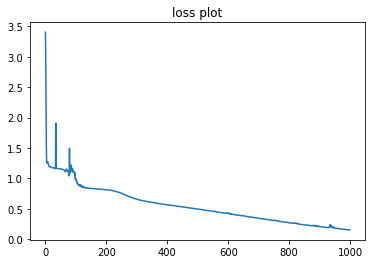

In [ ]:
plt.plot(range(0, n_epochs), losses)
plt.title("loss plot")
plt.show()

### inference

In [ ]:
def predict(model, character):
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character.to(device)
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden

In [ ]:
def call(model, out_len, start='hey'):
    model.eval() # eval mode
    start = start.lower()
    chars = [ch for ch in start]
    size = out_len - len(chars)
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

### example call

In [ ]:
call(model, 50, 'I').strip()

"i don't want to bother you"

# **TF** *playground*

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.models import load_model

from sklearn.model_selection import train_test_split

## Linear Regression

In [ ]:
xs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=float)
ys = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=float)
# ys = xs + 1

model = keras.Sequential([
    keras.layers.Dense(10, input_shape=[1]),
    keras.layers.Dense(1)
])
model.compile(loss='mae', optimizer='sgd', metrics=['accuracy'])
model.fit(xs, ys, epochs=500, verbose=0)

print(model.predict([11]))
print(model.predict([15]))

[[11.40785]]
[[15.199906]]


##  CNN - mnist classif

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

### preprocessing

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=0.2
)

In [ ]:
print('train X, Y shapes:', x_train.shape, y_train.shape)
print('validation X, Y shapes:', x_val.shape, y_val.shape)
print('test X, Y shapes:', x_test.shape, y_test.shape)

train X, Y shapes: (60000, 28, 28) (60000,)
validation X, Y shapes: (8000, 28, 28) (8000,)
test X, Y shapes: (2000, 28, 28) (2000,)


In [ ]:
x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_val = x_val.reshape(len(x_val), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

In [ ]:
print('train X, Y shapes:', x_train.shape, y_train.shape)
print('validation X, Y shapes:', x_val.shape, y_val.shape)
print('test X, Y shapes:', x_test.shape, y_test.shape)

train X, Y shapes: (60000, 28, 28, 1) (60000,)
validation X, Y shapes: (8000, 28, 28, 1) (8000,)
test X, Y shapes: (2000, 28, 28, 1) (2000,)


In [ ]:
x_train, x_val, x_test = x_train / 255.0, x_val, x_test / 255.0

### model

In [ ]:
from keras.backend import dropout
class EarlyStopping(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.995:
            self.model.stop_training=True


# currently [Conv64 x Pool x Conv32 x Pool x Dropout(.2) x Flatten x Dense128 x Dense10 best]
model = keras.Sequential([
    # comment-decomment structures to experiment with models
    keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # careful
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),  # interm layer takes input from previous
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Dropout(.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')                         
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### training

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping()]
)

Epoch 1/20
938/938 [==============================] - 86s 91ms/step - loss: 0.1520 - accuracy: 0.9529 - val_loss: 8.2769 - val_accuracy: 0.9827
Epoch 2/20
938/938 [==============================] - 86s 92ms/step - loss: 0.0480 - accuracy: 0.9854 - val_loss: 9.4640 - val_accuracy: 0.9826
Epoch 3/20
938/938 [==============================] - 86s 91ms/step - loss: 0.0331 - accuracy: 0.9898 - val_loss: 9.3723 - val_accuracy: 0.9841
Epoch 4/20
938/938 [==============================] - 85s 90ms/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 5.1833 - val_accuracy: 0.9920
Epoch 5/20
938/938 [==============================] - 84s 90ms/step - loss: 0.0214 - accuracy: 0.9929 - val_loss: 6.9751 - val_accuracy: 0.9908
Epoch 6/20
938/938 [==============================] - 85s 90ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 8.0648 - val_accuracy: 0.9901
Epoch 7/20
938/938 [==============================] - 84s 89ms/step - loss: 0.0145 - accuracy: 0.9951 - val_loss: 8.7391 - val_accuracy:

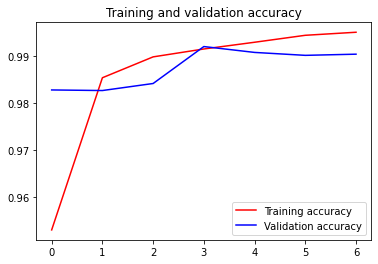

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_metrics(model_history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.show()


plot_metrics(history)

In [ ]:
# overfit for the greater good
# model.fit(
#     x_test,
#     y_test,
#     validation_data=(x_test, y_test),
#     epochs=5,
#     batch_size=64
# )

In [ ]:
model.save('model2xCPShDr.h5')

### evaluate

#### functions

In [ ]:
def evaluate(model, x_test, y_test):
    metrics = model.evaluate(x_test, y_test)

    model.summary()
    print(model.metrics_names)
    print(metrics)


    classif = model.predict(x_test)
    return classif

In [ ]:
def evaluate_random_sample(classif, x_test, y_test, idx=None):
    if not idx:
        idx = random.randint(0, len(y_test) - 1)
    print('# index {} of range [0, {})'.format(idx, len(y_test)))
    # #####
    X = x_test[idx].reshape((28, 28))
    plt.imshow(X)

    print('Ground truth:', y_test[idx])
    # highest value from the list of 10 probabilities, i.e. the value predicted by the model
    res = np.where(classif[idx] == np.amax(classif[idx]))[0] 
    print('Model classif:', np.amax(res))

In [ ]:
def get_rnd_misclassified_sample(classif, x_test, y_test):
    # checking which one is not correct
    while True:
        idx = random.randint(0, len(y_test) - 1)
        # #####
        X = x_test[idx].reshape((28, 28))

        # highest value from the list of 10 probabilities, i.e. the value predicted by the model
        res = np.where(classif[idx] == np.amax(classif[idx]))[0] 
        if y_test[idx] != np.amax(res):
            return idx

In [ ]:
def generate_classifier(model, x_test, y_test):
    if type(model) == str:
        print('$ importing model from {}'.format(model))
        model = load_model(model)
    else:
        # existing model
        print('$ using created model')
        pass

    classif = evaluate(
        model,
        x_test,
        y_test
    )
    return classif

#### callers

In [ ]:
classif = generate_classifier(
    # model='model2xCPShDr.h5',
    model=model,
    x_test=x_test,
    y_test=y_test
)

$ using created model
63/63 [==============================] - 2s 22ms/step - loss: 0.0146 - accuracy: 0.9945
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        73792     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 64)          0         
          

# index 464 of range [0, 2000)
Ground truth: 5
Model classif: 5


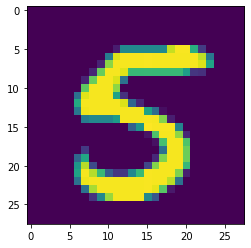

In [ ]:
evaluate_random_sample(
    classif,
    x_test,
    y_test,
    # idx=1569
)

# index 1808 of range [0, 2000)
Ground truth: 1
Model classif: 3


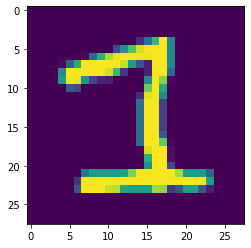

In [ ]:
evaluate_random_sample(
    classif,
    x_test,
    y_test,
    idx=get_rnd_misclassified_sample(
        classif,
        x_test,
        y_test
    )
)

## GPS positions

In [ ]:
import numpy as np
import geopy.distance

coords_1 = (47.71831512451172, 10.33071231842041)
coords_2 = (47.71836853027344, 10.330799102783203)

print(geopy.distance.vincenty(coords_1, coords_2).m)

8.812380468508415


In [ ]:
# %pip list

# sandbox

## scipy interpolate

 - theory: https://en.wikipedia.org/wiki/Runge's_phenomenon
 - scipy.interpolate: https://docs.scipy.org/doc/scipy/tutorial/interpolate.html

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
x = np.linspace(0, 10, num=11, endpoint=True)
xnew = np.linspace(0, 10, num=41, endpoint=True)

y = np.cos(-x**2/9.0)


f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

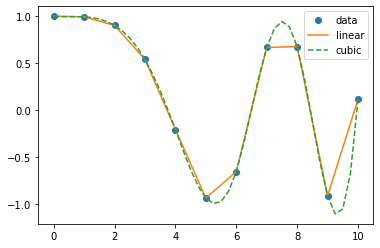

In [ ]:
plt.plot(x, y, 'o')
plt.plot(xnew, f(xnew), '-')
plt.plot(xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

## pyptoj transformations

* world CRS: 4326
* Russia CRS: 2694
* West Germany CRS: 4839

! solved, normalization + inverse normalization in the VP project

In [ ]:
!pip install pyproj --quiet
from pyproj import Transformer
x = [1, 2, 3, 4, 5]  # lon
y = x[::-1]  # lat

# transform every element to float ==> Transformer already does that
x = [elem * 1.0 for elem in x]
y = [elem * 1.0 for elem in y]

# transform from world coordinates to Russia coordinates
tr = Transformer.from_crs(4326, 2694)

x, y = tr.transform(x, y)

print('GK_x:', list(map(lambda elem: elem - 18272401.178585783, x)))
print('GK_y:', list(map(lambda elem: elem - 54094098.29760236, y)), end='\n\n')

# inverse transform from Russia coordinates to world coordinates
tr_inv = Transformer.from_crs(2694, 4326)

x, y = tr_inv.transform(x, y)

print('x:', x)
print('y:', y)

GK_x: [49105.86424013972]
GK_y: [4593.368673816323]

x: [10.329330445533541]
y: [47.71915435988313]


## random cells

In [ ]:
# pandas sandbox

a = [[1, 2, 3, 4], [5, 6, 7, 8]]
b = [[9, 10, 11, 12], [13, 14, 15, 16]]

import pandas as pd

x = pd.DataFrame(a)
y = pd.DataFrame(b)

x = pd.concat([x, y], axis=1, ignore_index=True)

print(x)

   0  1  2  3   4   5   6   7
0  1  2  3  4   9  10  11  12
1  5  6  7  8  13  14  15  16


In [ ]:
# see whether the list contains only lists of a certain length
a = [(1, 2), (3, 4, 5)]

print(all(map(lambda x: len(x) == 2, a)))

False


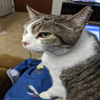

In [ ]:
# read an image from url using PIL.Image

from PIL import Image
import requests

im = Image.open(requests.get('https://i.imgur.com/yAsm4W7.jpeg', stream=True).raw)
im.resize((100, 100))

In [ ]:
# update a list of distances, i.e. each element is the sum of the previous elements => represent overall distance not separate distance between points

a = [1, 1.4142135623730951, 2.0, 1.4142135623730951, 2.0, 2.23606797749979, 1.0]

print([sum(a[:i]) for i in range(1, len(a) + 1)])

# for index, _ in enumerate(a):
#   print(index)

[1, 2.414213562373095, 4.414213562373095, 5.82842712474619, 7.82842712474619, 10.06449510224598, 11.06449510224598]


In [ ]:
# euclidian distance of two points
import numpy as np

p1 = [8.903305, 48.847046]
p2 = [8.901295, 48.841252]

print(np.linalg.norm(np.array(p1) - np.array(p2)))

0.006132742942600812


{50: 31.145084744485096,
 100: 74.17869892607294,
 150: 119.2790348348545,
 200: 188.49005675541005,
 250: 184.97464368498268,
 300: 276.6974989996251,
 350: 10.151829899265158,
 400: 186.24906175124215}


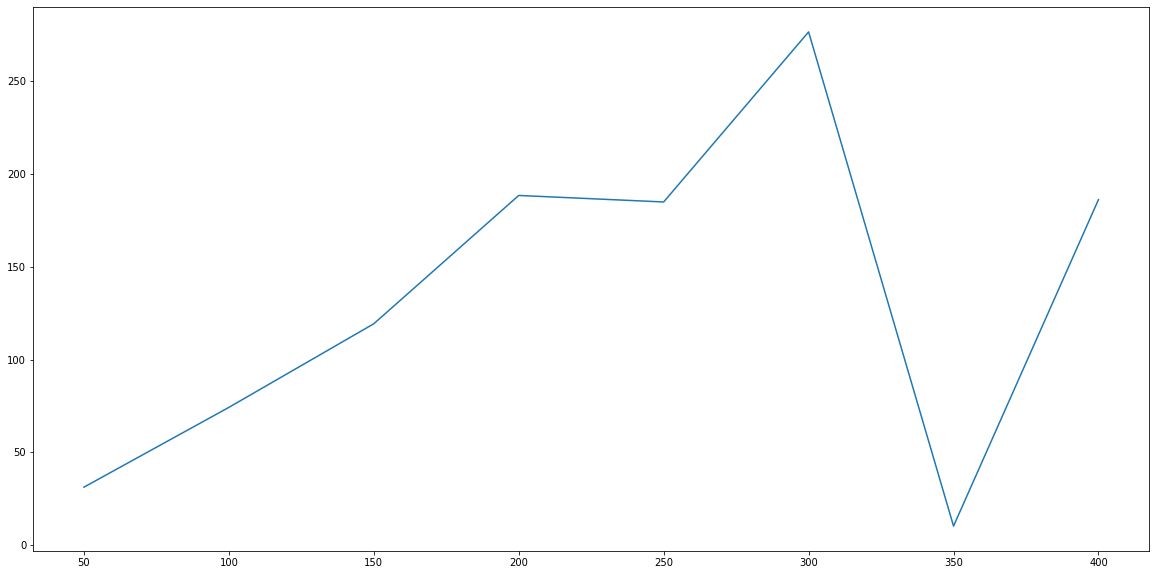

350 10.151829899265158


In [ ]:
import random
from pprint import pprint
import matplotlib.pyplot as plt

random.seed(5)

res = {}
for i in range(50, 450, 50):
    res[i] = random.random() * i

# ###
pprint(res)

# ###
plt.plot(list(res.keys()), list(res.values()))
plt.show()

min_ind = min(res, key=res.get)
print(min_ind, res[min_ind])

# savgol

In [ ]:
length = 0.5  # used for training 2000

SIZE = 5  # this is a silver lining :-??

STEP = 0.05

LR = 1e-4

In [ ]:
random.seed(17)

time = torch.tensor(np.arange(0, length, STEP))
sine = torch.sin(time)
cosine = torch.cos(time)

multiplier = 1
error = []
for elems in enumerate(sine):
  ind = elems[0]
  if ind % 100 == 0:  # 628 ~= 2*PI
    multiplier = round(random.uniform(1.0, 5.0), 2)
  error.append(sine[ind] - (cosine[ind] * multiplier))

print(length, len(error))
print('SIZE =', SIZE)

0.5 10
SIZE = 5


In [ ]:
from scipy.signal import savgol_filter

error_smooth = savgol_filter(error, 51, 1) # window size & polynomial order

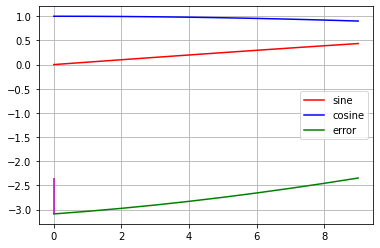

In [ ]:
plt.plot(sine, 'r', label='sine')
plt.plot(cosine, 'b', label='cosine')
plt.plot(error, 'g', label='error')
# plt.plot(error_smooth, 'y', label='error SMOOTH')

plt.vlines(length * 9 // 10 // STEP, ymin=np.array(error).min(), ymax=np.array(error).max(), colors='m')
plt.rcParams["figure.figsize"] = (20, 10)
plt.grid()
plt.legend()

# assign the smoothed sine wave to the error so it can work with it
# error = error_smooth